In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import os


In [2]:
# Load the data from the NPZ file from shooting method to validate model
loaded_data = np.load('../shooting_method/data_all.npz')

# Access the arrays using the keys ('r', 'A0', 'alpha0', 'phi0')
r = loaded_data['r']
A_shooting = loaded_data['A0']
alpha_shooting = loaded_data['alpha0']
phi_shooting = loaded_data['phi0']

function to define the nn architecture

In [3]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [4]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

define the model architecture

In [5]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model1 = FCN(1,4,64,4)#.to(device)
model2 = FCN(1,4,64,4)#.to(device)
model3 = FCN(1,4,64,4)#.to(device)
model4 = FCN(1,4,64,4)#.to(device)
model5 = FCN(1,4,64,4)#.to(device)


#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = 0.895042*torch.ones(1)#.to(device) 
phi0  = 0.05 * torch.ones(1)
#torch.nn.Parameter(0.895042*torch.ones(1))

load the models (same architecture, exported at different epochs)

In [6]:
device = torch.device("cpu")

dir = "../models/GPU_compact_x_fixed_omega/neurons64_h_layers4_n2000_sigma0.1/"
#dir = dir + "model_epoch200000_last_layer_retrain_initial_lr1e-05_gamma0.9999948706837163/"

# make out dir to save plots
out_dir = dir+"/plots/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# for training up to 2*10^5 epochs
model1.load_state_dict(torch.load(dir + "model_epoch50000.pth", map_location=device))
model2.load_state_dict(torch.load(dir + "model_epoch100000.pth", map_location=device))
model3.load_state_dict(torch.load(dir + "model_epoch200000.pth", map_location=device))
model4.load_state_dict(torch.load(dir + "model_epoch300000.pth", map_location=device))
model5.load_state_dict(torch.load(dir + "model_epoch400000.pth", map_location=device))

# for training up to 10^5 epochs
# model1.load_state_dict(torch.load(dir + "model_epoch20000.pth", map_location=device))
# model2.load_state_dict(torch.load(dir + "model_epoch40000.pth", map_location=device))
# model3.load_state_dict(torch.load(dir + "model_epoch60000.pth", map_location=device))
# model4.load_state_dict(torch.load(dir + "model_epoch80000.pth", map_location=device))
# model5.load_state_dict(torch.load(dir + "model_epoch100000.pth", map_location=device))

# load total loss list
loss_list = np.load(dir + "total_loss.npz")["loss"]
# load individual losses
losses = np.load(dir + "losses.npz")["loss"]
# load learning rate list
lr_list = np.load(dir + "learning_rate.npz")["lr"]


/tmp/ipykernel_11938/2680938315.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(dir + "model_epoch50000.pth", map_location=device))
/t

Text(0.5, 0, 'epochs')

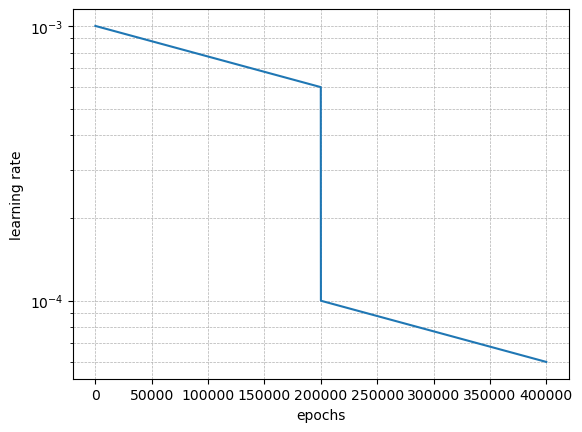

In [8]:
i = 1

ei = 0
ef = -1

# Plot in the second subplot
plt.semilogy(lr_list[ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylabel("learning rate")
plt.xlabel("epochs")
#plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


check values at x=0

In [9]:
R0 = torch.zeros(1, requires_grad=True)#.to(device)
nn_sol_r01 = model1(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r02 = model2(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r03 = model3(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r04 = model4(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r05 = model5(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A1, alpha1, chi1, phi1 = map(lambda i:  nn_sol_r01[[i]], range(4))
alphar1 = gradients(alpha1, R0)
A2, alpha2, chi2, phi2 = map(lambda i:  nn_sol_r02[[i]], range(4))
alphar2 = gradients(alpha2, R0)
A3, alpha3, chi3, phi3 = map(lambda i:  nn_sol_r03[[i]], range(4))
alphar3 = gradients(alpha3, R0)
A4, alpha4, chi4, phi4 = map(lambda i:  nn_sol_r04[[i]], range(4))
alphar4 = gradients(alpha4, R0)
A5, alpha5, chi5, phi5 = map(lambda i:  nn_sol_r05[[i]], range(4))
alphar5 = gradients(alpha5, R0)

print("A_nn_r01 =",A1.item())
print("A_nn_r02 =",A2.item())
print("A_nn_r03 =",A3.item())
print("A_nn_r04 =",A4.item())
print("A_nn_r05 =",A5.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r01 =",alpha1.item())
print("alpha_nn_r02 =",alpha2.item())
print("alpha_nn_r03 =",alpha3.item())
print("alpha_nn_r04 =",alpha4.item())
print("alpha_nn_r05 =",alpha5.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r01 =",chi1.item())
print("chi_nn_r02 =",chi2.item())
print("chi_nn_r03 =",chi3.item())
print("chi_nn_r04 =",chi4.item())
print("chi_nn_r05 =",chi5.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r01 =",phi1.item())
print("phi_nn_r02 =",phi2.item())
print("phi_nn_r03 =",phi3.item())
print("phi_nn_r04 =",phi4.item())
print("phi_nn_r05 =",phi5.item())
print("phi0_r0   =",phi0.item())
print("")

print("alphar_nn_r01 =",alphar1.item())
print("alphar_nn_r02 =",alphar2.item())
print("alphar_nn_r03 =",alphar3.item())
print("alphar_nn_r04 =",alphar4.item())
print("alphar_nn_r05 =",alphar5.item())
print("alphar_r0    =",0)

A_nn_r01 = 0.9998615980148315
A_nn_r02 = 1.000837802886963
A_nn_r03 = 0.99998539686203
A_nn_r04 = 0.9999936819076538
A_nn_r05 = 1.0000109672546387
A_r0    = 1

alpha_nn_r01 = 0.9989094734191895
alpha_nn_r02 = 0.9632617235183716
alpha_nn_r03 = 0.8315439820289612
alpha_nn_r04 = 0.8193573355674744
alpha_nn_r05 = 0.8132548332214355
alpha_r0    > 0

chi_nn_r01 = 6.192373689373198e-07
chi_nn_r02 = 6.168411800899776e-06
chi_nn_r03 = 2.9418843041639775e-06
chi_nn_r04 = 2.0459438019315712e-06
chi_nn_r05 = 1.5779328350618016e-06
chi_r0    = 0

phi_nn_r01 = 0.04995841905474663
phi_nn_r02 = 0.0501079335808754
phi_nn_r03 = 0.049999527633190155
phi_nn_r04 = 0.05000785365700722
phi_nn_r05 = 0.050001200288534164
phi0_r0   = 0.05000000074505806

alphar_nn_r01 = -4.07951301895082e-06
alphar_nn_r02 = 7.997557986527681e-06
alphar_nn_r03 = -1.503955218140618e-07
alphar_nn_r04 = -1.068336814569193e-07
alphar_nn_r05 = 1.4871218354528537e-06
alphar_r0    = 0


check values at training rmax

In [10]:
RMAX = 1 # it really is xmax=1
rmax = RMAX*torch.ones(1, requires_grad=True)#.to(device)
nn_sol_rmax = model5(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_rmax[[i]], range(4))
alphar = gradients(alpha, rmax)

print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 0.9999806880950928
A_rmax    = 1

alpha_nn_rmax = 1.0000147819519043
alpha_rmax    = 1

chi_nn_rmax = 1.2087703282759321e-08
chi_rmax    = 0

phi_nn_rmax = 1.8055012333206832e-05
phi0_rmax   = 0


get the solution of the nn for the exact r domain used by shooting

In [11]:
# the time domain; used to visualize the analytical solution
N = len(r) #1000
RMAX = r[-1]

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
RR = torch.linspace(0,RMAX,N).view(-1,1)#.to(device)
# compactify the R domain as x = r/(r+1)
XX = RR/(RR+1)

nn_sol1 = model1(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol2 = model2(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol3 = model3(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol4 = model4(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol5 = model5(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot

A_nn1, alpha_nn1, chi_nn1, phi_nn1 = map(lambda i:  nn_sol1[:,[i]], range(4))
A_nn2, alpha_nn2, chi_nn2, phi_nn2 = map(lambda i:  nn_sol2[:,[i]], range(4))
A_nn3, alpha_nn3, chi_nn3, phi_nn3 = map(lambda i:  nn_sol3[:,[i]], range(4))
A_nn4, alpha_nn4, chi_nn4, phi_nn4 = map(lambda i:  nn_sol4[:,[i]], range(4))
A_nn5, alpha_nn5, chi_nn5, phi_nn5 = map(lambda i:  nn_sol5[:,[i]], range(4))


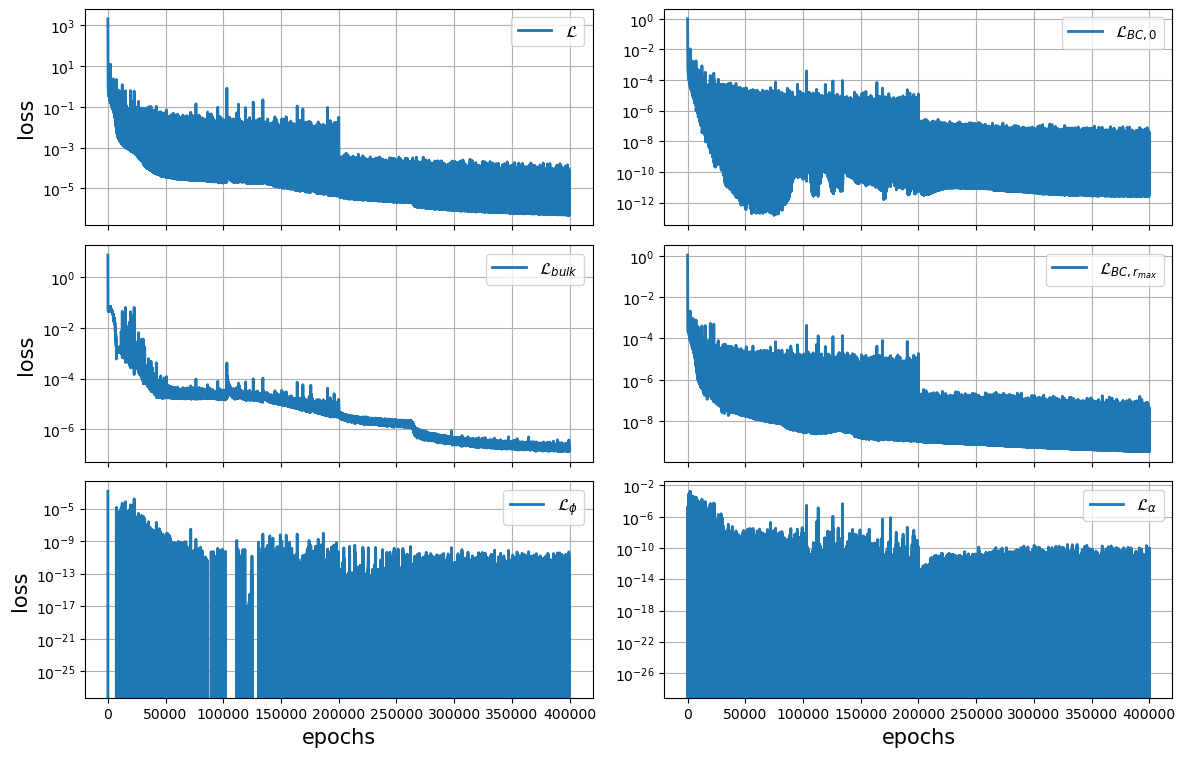

In [12]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12

step = 1

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# total loss

axs[0,0].plot(loss_list[0:-1:step], label=r"$\mathcal{L}$", lw=2, color="tab:blue",linestyle="-")
axs[0,0].set_yscale("log")
axs[0,0].grid(True)
axs[0,0].set_ylabel("loss", fontsize=l_size)
axs[0,0].legend(loc="upper right",fontsize=legend_fsize)
axs[0,0].set_xticklabels([])  # Remove x-axis tick labels

# loss at r0 (BC)

axs[0,1].plot(losses[0][0:-1:step], label=r"$\mathcal{L}_{BC,0}$", lw=2, color="tab:blue",linestyle="-")
axs[0,1].set_yscale("log")
axs[0,1].grid(True)
axs[0,1].set_xticklabels([])  # Remove x-axis tick labels
axs[0,1].legend(loc="upper right",fontsize=legend_fsize)
#axs[0,1].set_ylim(10**(-5),1)

# bulk loss

axs[1,0].plot(losses[1][0:-1:step], label=r"$\mathcal{L}_{bulk}$", lw=2, color="tab:blue",linestyle="-")
axs[1,0].set_yscale("log")
axs[1,0].grid(True)
axs[1,0].set_ylabel("loss", fontsize=l_size)
axs[1,0].set_xticklabels([])  # Remove x-axis tick label
axs[1,0].legend(loc="upper right",fontsize=legend_fsize)

# loss at rmax BC

axs[1,1].plot(losses[2][0:-1:step], label=r"$\mathcal{L}_{BC,r_{max}}$", lw=2, color="tab:blue",linestyle="-")
axs[1,1].set_yscale("log")
axs[1,1].grid(True)
axs[1,1].set_xticklabels([])  # Remove x-axis tick labels
axs[1,1].legend(loc="upper right",fontsize=legend_fsize)

# loss for phi monotonicity

axs[2,0].plot(losses[3][0:-1:step], label=r"$\mathcal{L}_{\phi}$", lw=2, color="tab:blue",linestyle="-")
axs[2,0].set_yscale("log")
axs[2,0].grid(True)
axs[2,0].set_ylabel("loss", fontsize=l_size)
axs[2,0].set_xlabel("epochs", fontsize=l_size)
axs[2,0].legend(loc="upper right",fontsize=legend_fsize)

# loss for alpha monotonicity

axs[2,1].plot(losses[4][0:-1:step], label=r"$\mathcal{L}_{\alpha}$", lw=2, color="tab:blue",linestyle="-")
axs[2,1].set_yscale("log")
axs[2,1].grid(True)
axs[2,1].set_xlabel("epochs", fontsize=l_size)
axs[2,1].legend(loc="upper right",fontsize=legend_fsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"losses.pdf")


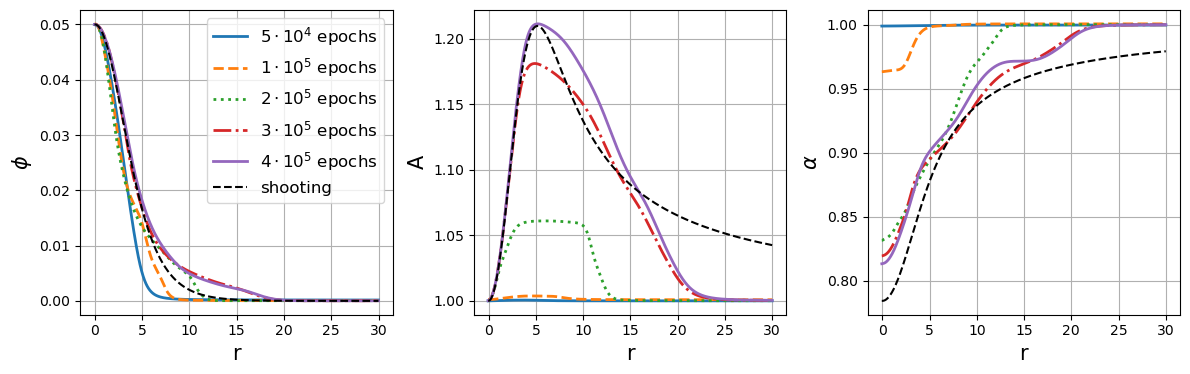

In [15]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12


# Create subplots
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# phi sols

axs[0].plot(r, phi_nn1, label=r"$5 \cdot 10^4$"+" epochs", lw=2, color="tab:blue",linestyle="-")
axs[0].plot(r, phi_nn2, label=r"$1 \cdot 10^5$"+" epochs", lw=2, color="tab:orange",linestyle="--")
axs[0].plot(r, phi_nn3, label=r"$2 \cdot 10^5$"+" epochs", lw=2, color="tab:green",linestyle=":")
axs[0].plot(r, phi_nn4, label=r"$3 \cdot 10^5$"+" epochs", lw=2, color="tab:red",linestyle="-.")
axs[0].plot(r, phi_nn5, label=r"$4 \cdot 10^5$"+" epochs", lw=2, color="tab:purple",linestyle="-")
axs[0].plot(r, phi_shooting, label="shooting", lw=1.5, color="black",linestyle="--")
axs[0].grid(True)
axs[0].set_ylabel(r"$\phi$", fontsize=l_size)
axs[0].legend(loc="upper right",fontsize=legend_fsize)
#axs[0].set_xticklabels([])  # Remove x-axis tick label
axs[0].set_xlabel("r", fontsize=l_size)

# A sols
axs[1].plot(r, A_nn1, lw=2, color="tab:blue",linestyle="-")
axs[1].plot(r, A_nn2, lw=2, color="tab:orange",linestyle="--")
axs[1].plot(r, A_nn3, lw=2, color="tab:green",linestyle=":")
axs[1].plot(r, A_nn4, lw=2, color="tab:red",linestyle="-.")
axs[1].plot(r, A_nn5, lw=2, color="tab:purple",linestyle="-")
axs[1].plot(r, A_shooting, lw=1.5, color="black",linestyle="--")
axs[1].grid(True)
axs[1].set_ylabel("A", fontsize=l_size)
#axs[1].set_xticklabels([])  # Remove x-axis tick label
axs[1].set_xlabel("r", fontsize=l_size)

# alpha sol
axs[2].plot(r, alpha_nn1, lw=2, color="tab:blue",linestyle="-")
axs[2].plot(r, alpha_nn2, lw=2, color="tab:orange",linestyle="--")
axs[2].plot(r, alpha_nn3, lw=2, color="tab:green",linestyle=":")
axs[2].plot(r, alpha_nn4, lw=2, color="tab:red",linestyle="-.")
axs[2].plot(r, alpha_nn5, lw=2, color="tab:purple",linestyle="-")
axs[2].plot(r, alpha_shooting, lw=1.5, color="black",linestyle="--")
axs[2].grid(True)
axs[2].set_ylabel(r"$\alpha$", fontsize=l_size)
axs[2].set_xlabel("r", fontsize=l_size)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"solutions.pdf")


In [40]:
def err(nn_sol, shooting_sol):
    return np.abs(nn_sol.flatten() - shooting_sol), np.abs(nn_sol.flatten() - shooting_sol)/np.abs(shooting_sol)


nn1_abs_phi_err, nn1_rel_phi_err = err(phi_nn1, phi_shooting)
nn2_abs_phi_err, nn2_rel_phi_err = err(phi_nn2, phi_shooting)
nn3_abs_phi_err, nn3_rel_phi_err = err(phi_nn3, phi_shooting)
nn4_abs_phi_err, nn4_rel_phi_err = err(phi_nn4, phi_shooting)
nn5_abs_phi_err, nn5_rel_phi_err = err(phi_nn5, phi_shooting)

nn1_abs_A_err, nn1_rel_A_err = err(A_nn1, A_shooting)
nn2_abs_A_err, nn2_rel_A_err = err(A_nn2, A_shooting)
nn3_abs_A_err, nn3_rel_A_err = err(A_nn3, A_shooting)
nn4_abs_A_err, nn4_rel_A_err = err(A_nn4, A_shooting)
nn5_abs_A_err, nn5_rel_A_err = err(A_nn5, A_shooting)

nn1_abs_alpha_err, nn1_rel_alpha_err = err(alpha_nn1, alpha_shooting)
nn2_abs_alpha_err, nn2_rel_alpha_err = err(alpha_nn2, alpha_shooting)
nn3_abs_alpha_err, nn3_rel_alpha_err = err(alpha_nn3, alpha_shooting)
nn4_abs_alpha_err, nn4_rel_alpha_err = err(alpha_nn4, alpha_shooting)
nn5_abs_alpha_err, nn5_rel_alpha_err = err(alpha_nn5, alpha_shooting)

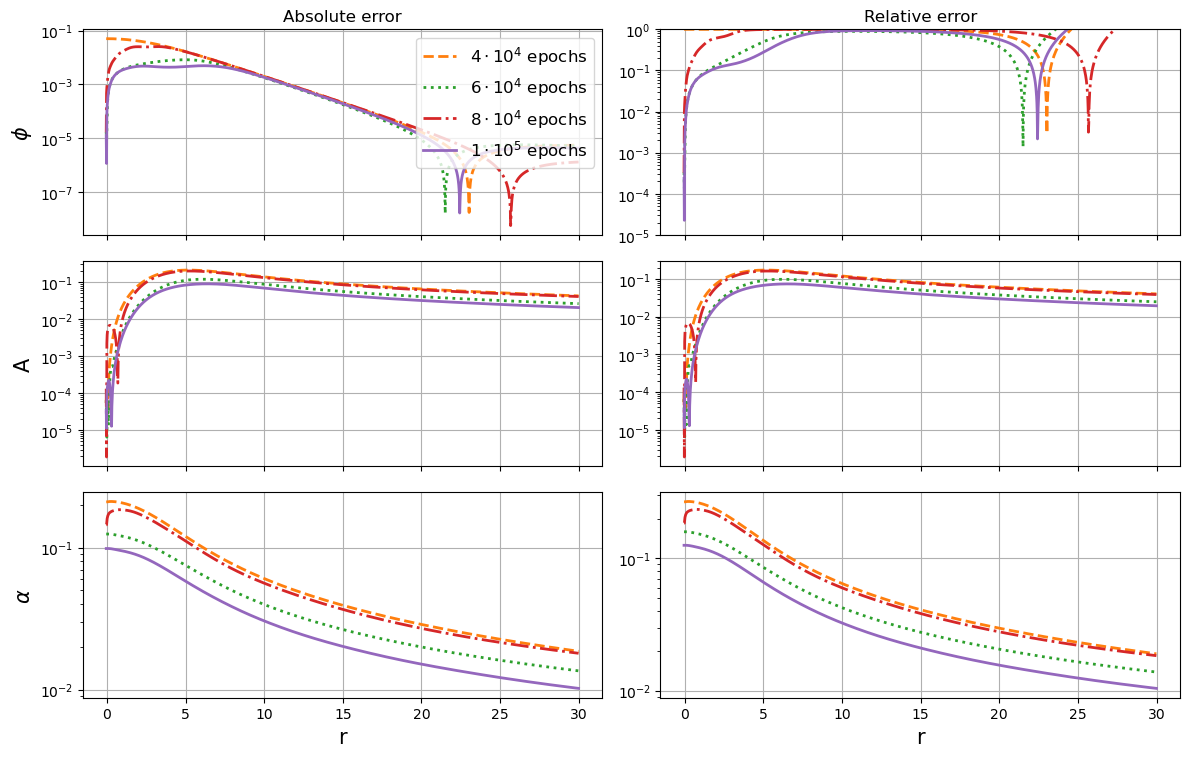

In [41]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# phi error

axs[0,0].set_title("Absolute error")
#axs[0,0].plot(r, nn1_abs_phi_err, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:blue",linestyle="-")
axs[0,0].plot(r, nn2_abs_phi_err, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:orange",linestyle="--")
axs[0,0].plot(r, nn3_abs_phi_err, label=r"$6 \cdot 10^4$"+" epochs", lw=2, color="tab:green",linestyle=":")
axs[0,0].plot(r, nn4_abs_phi_err, label=r"$8 \cdot 10^4$"+" epochs", lw=2, color="tab:red",linestyle="-.")
axs[0,0].plot(r, nn5_abs_phi_err, label=r"$1 \cdot 10^5$"+" epochs", lw=2, color="tab:purple",linestyle="-")
axs[0,0].set_yscale("log")
axs[0,0].grid(True)
axs[0,0].set_ylabel(r"$\phi$", fontsize=l_size)
axs[0,0].legend(loc="upper right",fontsize=legend_fsize)
axs[0,0].set_xticklabels([])  # Remove x-axis tick labels

axs[0,1].set_title("Relative error")
#axs[0,1].plot(r, nn1_rel_phi_err, lw=2, color="tab:blue",linestyle="-")
axs[0,1].plot(r, nn2_rel_phi_err, lw=2, color="tab:orange",linestyle="--")
axs[0,1].plot(r, nn3_rel_phi_err, lw=2, color="tab:green",linestyle=":")
axs[0,1].plot(r, nn4_rel_phi_err, lw=2, color="tab:red",linestyle="-.")
axs[0,1].plot(r, nn5_rel_phi_err, lw=2, color="tab:purple",linestyle="-")
axs[0,1].set_yscale("log")
axs[0,1].grid(True)
axs[0,1].set_xticklabels([])  # Remove x-axis tick labels
axs[0,1].set_ylim(10**(-5),1)

# A error

#axs[1,0].plot(r, nn1_abs_A_err, lw=2, color="tab:blue",linestyle="-")
axs[1,0].plot(r, nn2_abs_A_err, lw=2, color="tab:orange",linestyle="--")
axs[1,0].plot(r, nn3_abs_A_err, lw=2, color="tab:green",linestyle=":")
axs[1,0].plot(r, nn4_abs_A_err, lw=2, color="tab:red",linestyle="-.")
axs[1,0].plot(r, nn5_abs_A_err, lw=2, color="tab:purple",linestyle="-")
axs[1,0].set_yscale("log")
axs[1,0].grid(True)
axs[1,0].set_ylabel("A", fontsize=l_size)
axs[1,0].set_xticklabels([])  # Remove x-axis tick labels

#axs[1,1].plot(r, nn1_rel_A_err, lw=2, color="tab:blue",linestyle="-")
axs[1,1].plot(r, nn2_rel_A_err, lw=2, color="tab:orange",linestyle="--")
axs[1,1].plot(r, nn3_rel_A_err, lw=2, color="tab:green",linestyle=":")
axs[1,1].plot(r, nn4_rel_A_err, lw=2, color="tab:red",linestyle="-.")
axs[1,1].plot(r, nn5_rel_A_err, lw=2, color="tab:purple",linestyle="-")
axs[1,1].set_yscale("log")
axs[1,1].grid(True)
axs[1,1].set_xticklabels([])  # Remove x-axis tick labels

# alpha error

#axs[2,0].plot(r, nn1_abs_alpha_err, lw=2, color="tab:blue",linestyle="-")
axs[2,0].plot(r, nn2_abs_alpha_err, lw=2, color="tab:orange",linestyle="--")
axs[2,0].plot(r, nn3_abs_alpha_err, lw=2, color="tab:green",linestyle=":")
axs[2,0].plot(r, nn4_abs_alpha_err, lw=2, color="tab:red",linestyle="-.")
axs[2,0].plot(r, nn5_abs_alpha_err, lw=2, color="tab:purple",linestyle="-")
axs[2,0].set_yscale("log")
axs[2,0].grid(True)
axs[2,0].set_ylabel(r"$\alpha$", fontsize=l_size)
axs[2,0].set_xlabel("r", fontsize=l_size)

#axs[2,1].plot(r, nn1_rel_alpha_err, lw=2, color="tab:blue",linestyle="-")
axs[2,1].plot(r, nn2_rel_alpha_err, lw=2, color="tab:orange",linestyle="--")
axs[2,1].plot(r, nn3_rel_alpha_err, lw=2, color="tab:green",linestyle=":")
axs[2,1].plot(r, nn4_rel_alpha_err, lw=2, color="tab:red",linestyle="-.")
axs[2,1].plot(r, nn5_rel_alpha_err, lw=2, color="tab:purple",linestyle="-")
axs[2,1].set_yscale("log")
axs[2,1].grid(True)
axs[2,1].set_xlabel("r", fontsize=l_size)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"errors.pdf")


(0.0, 30.0)

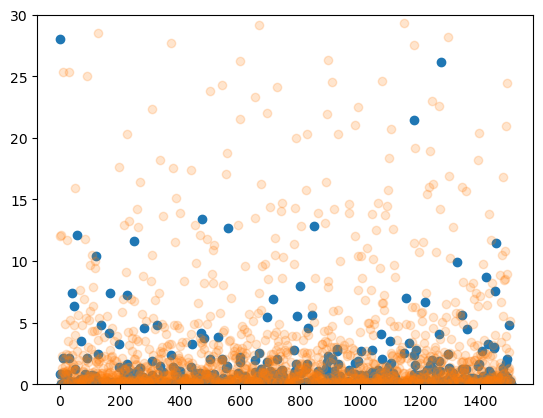

In [ ]:
# to check the random points sampling
sigma = 0.1

# generate random points for (0,1)
n_rand = np.random.rand(N)
# make them dense near x=0
x_n_rand = (np.sinh(n_rand/sigma)/np.sinh(1/sigma))

#x_n_rand = n_rand
# transform them from (0,1) to (0,rmax)

r_n_rand = x_n_rand/(1-x_n_rand)
r2_n_rand = n_rand/(1-n_rand)

plt.scatter(range(N),r_n_rand)

plt.scatter(range(N),r2_n_rand, alpha=0.2)

plt.ylim(0,30)